In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import MetaTrader5 as mt5
from account_credentials import LOGIN,PASSWORD,SERVER
from datetime import datetime


In [75]:
is_initialized = mt5.initialize()
print('initialize: ', is_initialized)

is_logged_in = mt5.login(LOGIN, PASSWORD, SERVER)
print('logged in: ', is_logged_in)
print('\n')
account_info = mt5.account_info()
print(datetime.now(),
    '| Login: ', account_info.login,
    '| Balance: ', account_info.balance,
    '| Equity: ' , account_info.equity)

initialize:  True
logged in:  True


2023-04-23 15:41:57.736487 | Login:  114123121 | Balance:  484.96 | Equity:  484.96


In [76]:
symbol = 'XAUUSD'
number_of_date= 10000
timeframe = mt5.TIMEFRAME_H1
from_date = datetime.now()

df = pd.DataFrame(mt5.copy_rates_from(symbol,timeframe,from_date,number_of_date))
df["time"] = pd.to_datetime(df["time"], unit="s")
df = df.rename(columns={'time': 'date','tick_volume':'volume'})
df = df[['date','open','high','low','close','volume']]
df = df.set_index("date")
print(df.head()) # just to make sure that sorted from old to new

                         open      high       low     close  volume
date                                                               
2021-08-12 06:00:00  1751.431  1755.947  1750.567  1752.946    4305
2021-08-12 07:00:00  1752.915  1758.143  1751.801  1756.810    4421
2021-08-12 08:00:00  1756.808  1757.641  1753.819  1755.787    3569
2021-08-12 09:00:00  1755.788  1756.388  1753.587  1753.790    2980
2021-08-12 10:00:00  1753.793  1753.846  1750.953  1751.065    3226


##### Adding Features

In [77]:
df['RSI'] = ta.rsi(df.close, length = 15)
df['EMAF'] = ta.ema(df.close, length = 20)
df['EMAM'] = ta.ema(df.close, length = 100)
df['EMAS'] = ta.ema(df.close, length = 150)
# df['Target'] = df['close'] - df.open
# df['Target'] = df['Target'].shift(-1)

# df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df['Target-Next-Close'] = df['close'].shift(-1)



df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['date','volume'], axis=1 , inplace=True)
# df = df[0:100]
df

,open,high,low,close,RSI,EMAF,EMAM,EMAS,Target-Next-Close
0,1784.936,1786.677,1783.537,1783.832,50.503467,1783.541223,1780.379723,1777.868453,1782.727
1,1783.863,1784.365,1781.711,1782.727,48.117336,1783.463678,1780.426203,1777.932805,1782.732
2,1782.729,1783.093,1781.854,1782.732,48.129217,1783.393994,1780.471863,1777.996370,1782.390
3,1782.712,1783.168,1782.049,1782.390,47.334808,1783.298376,1780.509846,1778.054564,1781.291
4,1782.457,1782.457,1780.318,1781.291,44.789464,1783.107197,1780.525314,1778.097431,1778.198
...,...,...,...,...,...,...,...,...,...
9845,1978.879,1979.753,1974.409,1975.846,31.199011,1989.756309,1998.469986,2000.369907,1977.473
9846,1975.882,1978.534,1974.025,1977.473,33.699529,1988.586470,1998.054204,2000.066637,1980.601
9847,1977.442,1980.706,1977.400,1980.601,38.317385,1987.825949,1997.708596,1999.808814,1979.144
9848,1980.631,1982.496,1978.914,1979.144,37.030215,1986.999096,1997.340980,1999.535108,1982.674


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler_x = StandardScaler().fit(df.iloc[:,:8])
scaled_x = scaler_x.transform(df.iloc[:,:8])
scaler_y = StandardScaler().fit(df.iloc[:,8].values.reshape(-1, 1))
scaled_y = scaler_y.transform(df.iloc[:,8].values.reshape(-1, 1))
scaled_x.shape

In [78]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaled_x = scaler_x.fit_transform(df.iloc[:,:8])
print(scaled_x.shape)
scaled_x

(9850, 8)


array([[0.37156586, 0.36960159, 0.38677736, ..., 0.38140755, 0.37021538,
        0.36342155],
       [0.36919639, 0.36446401, 0.38259677, ..., 0.38122005, 0.37033731,
        0.36359513],
       [0.36669221, 0.36163745, 0.38292417, ..., 0.38105157, 0.37045708,
        0.36376658],
       ...,
       [0.79667125, 0.80076086, 0.83062221, ..., 0.87534371, 0.94031824,
        0.96206267],
       [0.80371343, 0.80473849, 0.83408848, ..., 0.87334448, 0.9393539 ,
        0.9613244 ],
       [0.80036127, 0.80586067, 0.83349093, ..., 0.87234852, 0.93859202,
        0.96072202]])

In [79]:
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_y = scaler_y.fit_transform(df.iloc[:,8].values.reshape(-1, 1))
print(scaled_y.shape)
scaled_y

(9850, 1)


array([[0.36670171],
       [0.36671275],
       [0.36595746],
       ...,
       [0.800481  ],
       [0.80827687],
       [0.80882899]])

In [70]:
# # Save the array to a CSV file
# np.savetxt('arrayx.csv', scaled_x, delimiter=',')
# np.savetxt('arrayy.csv', scaled_y, delimiter=',')

In [80]:
X = []
backcandles = 30
print(scaled_x.shape[0])
for j in range(8): 
    X.append([])
    for i in range(0, scaled_x.shape[0]-backcandles+1):
        X[j].append(scaled_x[i:i+backcandles, j])
print(np.array(X).shape)

X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
print(X.shape)

9850
(8, 9821, 30)
(9821, 30, 8)


In [ ]:
# X = []
# backcandles = 30
# print(df_a.shape[0])
# for j in range(8): # grabe open	high	low	close	RSI	EMAF	EMAM	EMAS
#     X.append([])
#     for i in range(backcandles, df_a.shape[0]):
#         X[j].append(df_a[i-backcandles:i, j])
# X=np.moveaxis(X, [0], [2])
# X.shape


# X = []
# backcandles = 30
# print(scaled_x.shape[0])
# for j in range(8): 
#     X.append([])
#     for i in range(backcandles, scaled_x.shape[0]):
#         X[j].append(scaled_x[i-backcandles:i, j])
# X = np.moveaxis(X, [0], [2])  # move the feature axis to the second dimension
# X = X[::-1]  # reverse the order of the samples to put the most recent data at the end
# X.shape


In [ ]:
X[0,0,:]

In [ ]:
X[0,1,:]

In [84]:
# X = X
y = scaled_y[(scaled_y.shape[0]-X.shape[0]):,:] # matching the shape of X
# y = np.reshape(y,(len(y),1))
print(X.shape) # 3D X has 8 colume and each colume contain xx backcandles (row, backcandle, column)
print(y.shape) # 2D contain 1 value (it's 1D array that reshape into 2D array)
print(y)

(9821, 30, 8)
(9821, 1)
[[0.40924771]
 [0.41392081]
 [0.41112048]
 ...
 [0.800481  ]
 [0.80827687]
 [0.80882899]]


In [85]:
proportion = int(len(X)*0.8)
X_train, X_test = X[:proportion],X[proportion:]
y_train, y_test = y[:proportion],y[proportion:]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X[1,1:10,1])

(7856, 30, 8)
(7856, 1)
(1965, 30, 8)
(1965, 1)
[0.36163745 0.36180411 0.36022417 0.35996418 0.35298    0.35420217
 0.36870385 0.37244371 0.37403476]


In [86]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the Sequential model
model = Sequential()

# Add the LSTM layer with 150 units and input shape (backcandles, 8)
model.add(LSTM(units=150, input_shape=(backcandles, 8), name='lstm_layer'))

# Add a dense layer with a single output neuron and linear activation function
model.add(Dense(units=1, activation='linear', name='output'))

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data with a batch size of 15 and for 30 epochs
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_data=(X_test, y_test))


Epoch 1/30
524/524 [==============================] - 6s 9ms/step - loss: 0.0016 - val_loss: 1.4722e-04
Epoch 2/30
524/524 [==============================] - 4s 8ms/step - loss: 1.2276e-04 - val_loss: 1.1388e-04
Epoch 3/30
524/524 [==============================] - 4s 8ms/step - loss: 1.1538e-04 - val_loss: 1.5045e-04
Epoch 4/30
524/524 [==============================] - 4s 7ms/step - loss: 9.5609e-05 - val_loss: 1.3173e-04
Epoch 5/30
524/524 [==============================] - 4s 8ms/step - loss: 1.0686e-04 - val_loss: 1.7892e-04
Epoch 6/30
524/524 [==============================] - 4s 7ms/step - loss: 9.4222e-05 - val_loss: 1.7867e-04
Epoch 7/30
524/524 [==============================] - 4s 8ms/step - loss: 1.0414e-04 - val_loss: 1.1202e-04
Epoch 8/30
524/524 [==============================] - 4s 7ms/step - loss: 9.0341e-05 - val_loss: 1.1620e-04
Epoch 9/30
524/524 [==============================] - 4s 7ms/step - loss: 8.9197e-05 - val_loss: 1.0334e-04
Epoch 10/30
524/524 [===========

In [87]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_layer (LSTM)           (None, 150)               95400     
                                                                 
 output (Dense)              (None, 1)                 151       
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [89]:
y_hat = model.predict(X_test)
for i in range(10):
    print(y_hat[i], y_test[i])

62/62 [==============================] - 0s 4ms/step
[0.3833272] [0.38014019]
[0.37902093] [0.38969841]
[0.38995907] [0.39183841]
[0.39239052] [0.41190007]
[0.41227219] [0.4208355]
[0.42082703] [0.41936909]
[0.41933134] [0.42188894]
[0.42190462] [0.40652689]
[0.40476483] [0.41728209]
[0.41381556] [0.43233496]


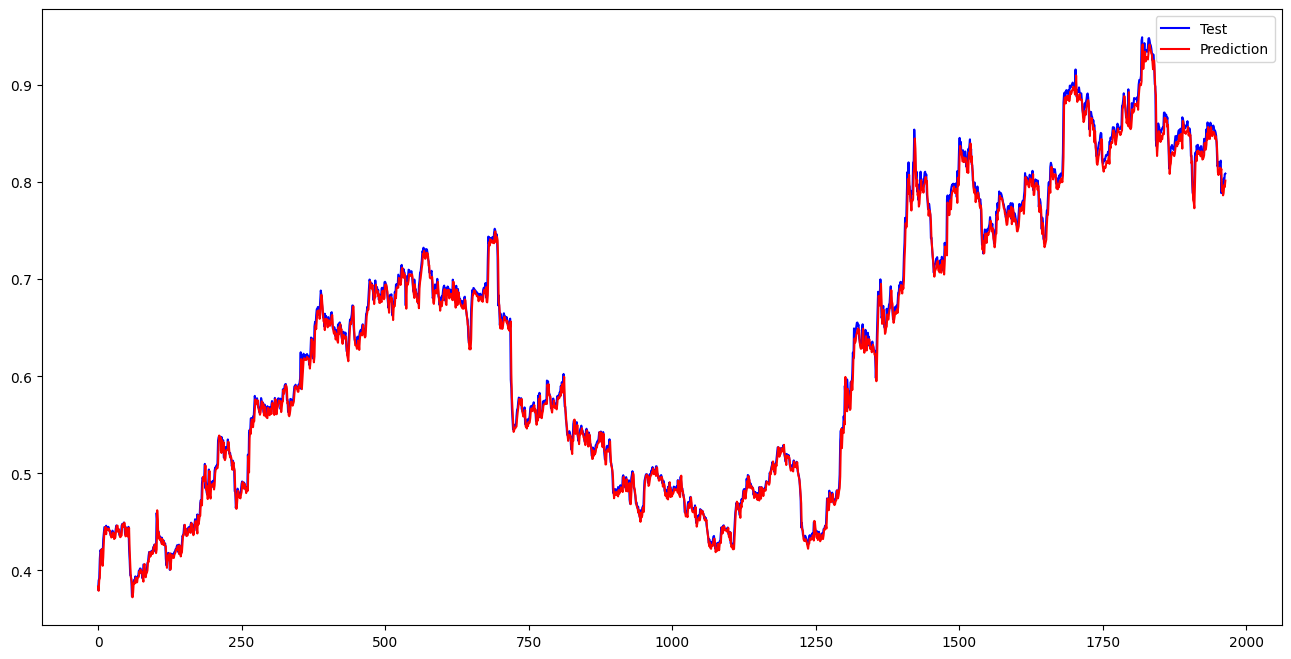

In [90]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_hat, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [91]:
y_hat_inverse = scaler_y.inverse_transform(y_hat)
print(y_hat_inverse)
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_test_inverse)

[[1790.2551]
 [1788.3052]
 [1793.258 ]
 ...
 [1977.6285]
 [1976.6627]
 [1979.6476]]
[[1788.812]
 [1793.14 ]
 [1794.109]
 ...
 [1979.144]
 [1982.674]
 [1982.924]]


In [103]:
diff = []
for i in range(0,len(y_hat_inverse)):
    val = float(y_hat_inverse[i] - y_test_inverse[i])
    diff.append(val)
sum(diff)/len(diff)

-1.704182972527041

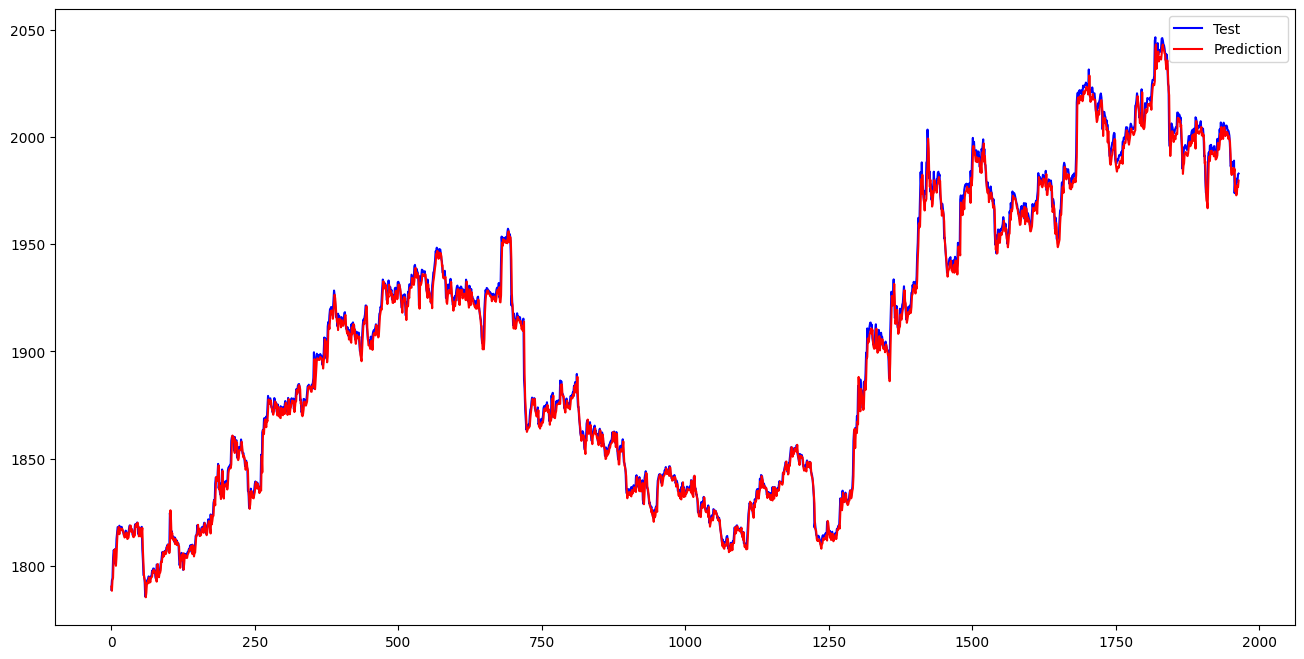

In [92]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inverse, color = 'blue', label = 'Test')
plt.plot(y_hat_inverse, color = 'red', label = 'Prediction')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)

# Print the mean squared error loss
print('Test loss:', loss)

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Compute the mean squared error (MSE) and root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Compute the coefficient of determination (R-squared)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print("TEST SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)
print()

loss = model.evaluate(X_train, y_train)
print('Training loss:', loss)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_train, y_pred)
print("TRAINING SET")
print('Mean squared error (MSE):', mse)
print('Root mean squared error (RMSE):', rmse)
print('R-squared (R2):', r2)

In [ ]:
if prediction - close > 3 then buy
if target > 3 then buy is correct
This is correct
else false

if prediction - close < 3 then sell
if target > 3 then sell is correct
This is correct
else false

if prediction - close > 3 AND prediction - close < 3 then doing nothing

# with a single model it cannot predict sell and buy at the sametime

In [ ]:
# float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
# y_hat = model.predict(X_test)
# float(y_hat[0])
scaled_sample_x = scaler_x.inverse_transform(X_train[0, :, :])
scaled_sample_x[0,4]
# y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
def predict_simu(model, X_test, data_simu_y, initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    for i in range(0, len(X_test)):
        prediction = float(model.predict(X_test[0, :, :].reshape(1, 30, 8)))
        
        if prediction == 1 and data_simu_y[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'win'
        elif prediction == 1 and data_simu_y[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- prediction = {0}, actual = {1}'.format(prediction,data_simu_y[i])
            result = 'lost'
        elif prediction == 0:
            no_order_count +=1
            order_record = 'no order--- prediction = {0}, actual = {1}'.format(prediction, data_simu_y[i])
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(X_test.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max
